In [1]:
import graph_tool.all as gt
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline
plt.rcParams.update({'font.size': 6})
plt.rcParams['figure.dpi'] = 300
random.seed(2022)
gt.openmp_set_schedule("auto")

In [2]:
def qt_draw2(g,axis_pos):
    pos = nx.shell_layout(g)
    nx.draw_networkx(G=g, pos=pos,node_size=80, ax=axis_pos, with_labels=False,connectionstyle="arc3,rad=0.1",node_color="#750101",edgecolors="#000000")

In [3]:
graph = gt.load_graph("data/ecoli2k.graphml")
gt.remove_self_loops(graph)

In [4]:
motif_size = 3
# motif_significance -> [motifs,scores,counts,avgs,stds]
erdos = gt.motif_significance(graph,motif_size,full_output=True,shuffle_model="erdos")
deg_seq = gt.motif_significance(graph,k=motif_size,motif_list=erdos[0],full_output=True,shuffle_model="configuration")

In [5]:
n_motifs    = len(erdos[0])
tot_plots   = n_motifs + 4
base        = math.ceil(math.sqrt(tot_plots))
height      = math.ceil((tot_plots)/base)

In [6]:
motifs_nx = list()
for subg in erdos[0]:
    el = list()
    el += subg.iter_edges()
    motifs_nx += [nx.from_edgelist(el,create_using=nx.DiGraph())]

In [7]:
def get_norm_zscores(scores:list)->list:
    """Returns z_scores: `z = (z-min)/(max-min)`"""
    max_val = max(scores)
    min_val = min(scores)
    retval = list()
    for i in scores:
        val = (i-min_val)/(max_val-min_val)
        retval.append(val)
    return retval

def get_count_perc_diff(counts:list,avgs:list)->list:
    """Returns counts: `c = (c-avg)/(100*floor(abs(avg)))
    if avg != 0 else 0`
    """
    delta_avg_diff = list()
    for i,j in zip(counts,avgs):
        delta_avg_diff.append(float((i-j)/(100*math.floor(abs(j)))) if math.floor(abs(j)) != 0 else 0)
    return delta_avg_diff

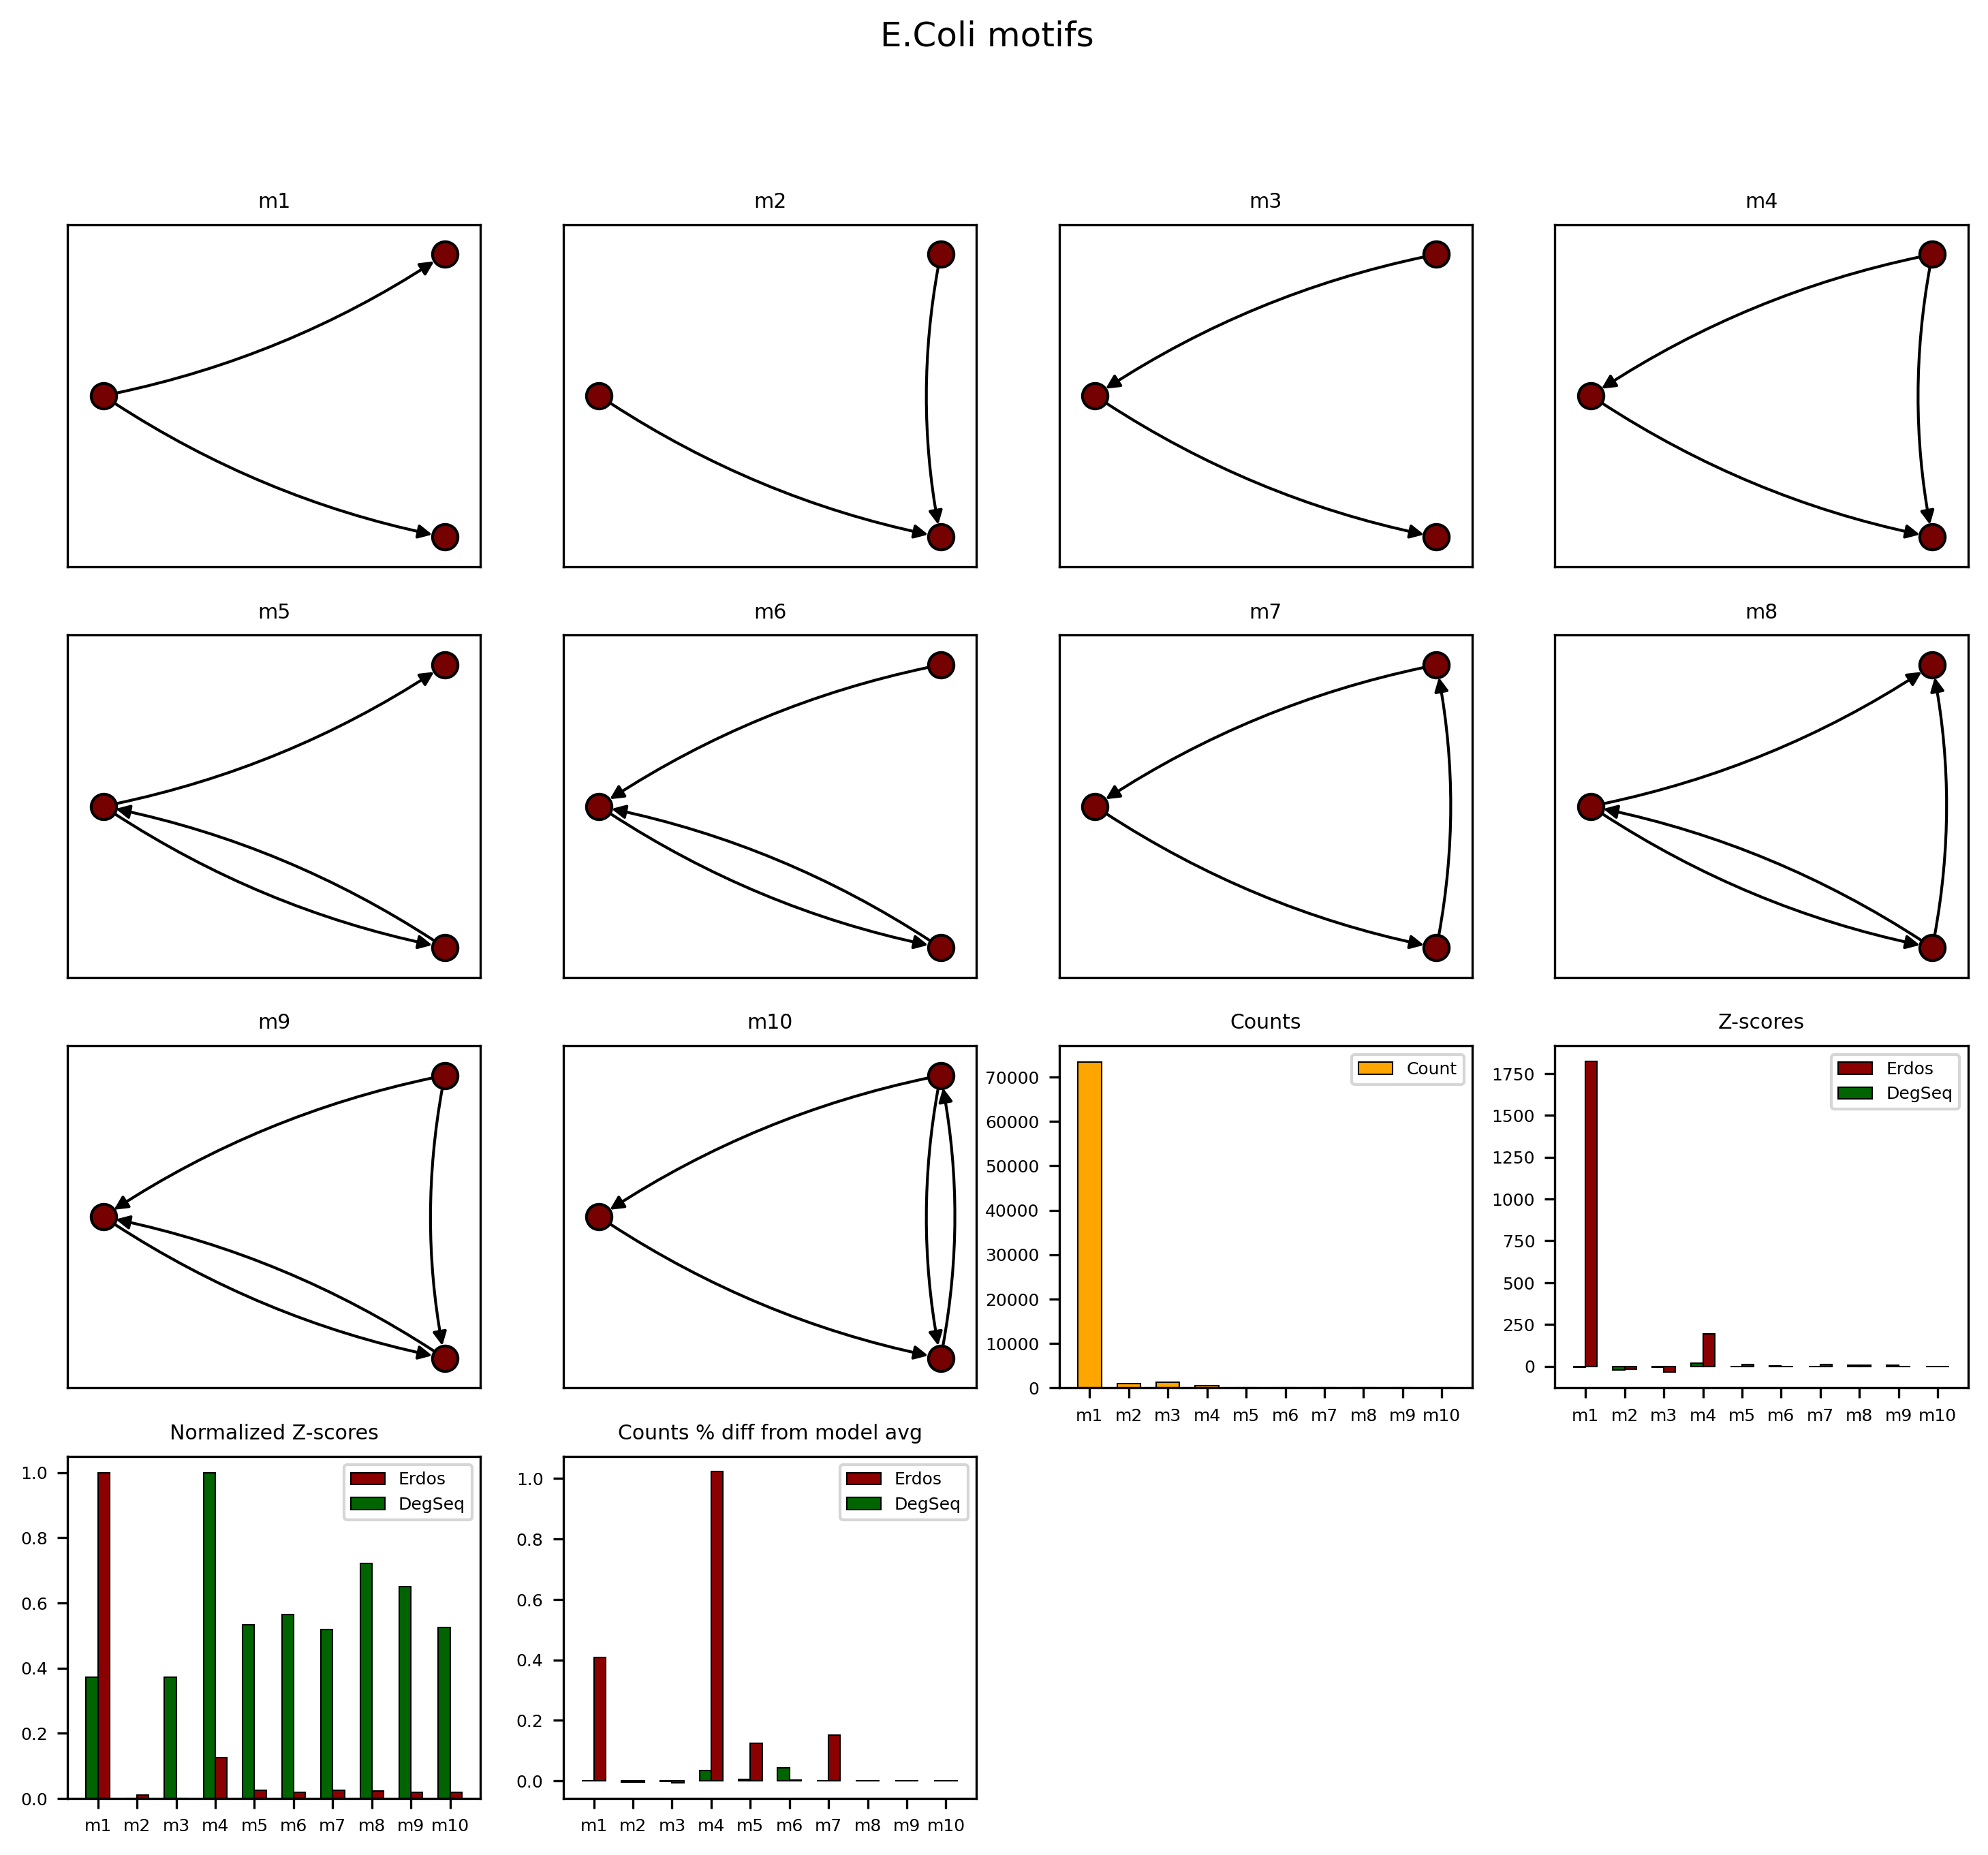

In [8]:
fig, ax     = plt.subplots(height, base, figsize=(12, 10))
fig.suptitle("E.Coli motifs",fontsize=12)
for i,motif in enumerate(motifs_nx,1):
    try:
        y = ((i-1) % base)
        x = math.floor((i-1)/base)
        ax[x,y].set_title(f"m{i}")
        # gt.graph_draw(motif,mplfig=ax[x,y],nodesfirst=True)
        # nx.draw_networkx(motif,ax=ax[x,y],with_labels=False)
        qt_draw2(g=motif,axis_pos=ax[x,y])
    except IndexError:
        print(i,x,y)
# len(sig_list[0])
n = list()
for i in range(1,n_motifs+1):
    n += [f"m{i}"]

i = n_motifs+1
y = ((i-1) % base)
x = math.floor((i-1)/base)
ax[x,y].set_title("Counts")
ax[x,y].bar(n,erdos[2],color="orange",align="center",width=0.6,edgecolor="black",linewidth=0.5,label="Count")
ax[x,y].legend()

i = n_motifs+2
y = ((i-1) % base)
x = math.floor((i-1)/base)
ax[x,y].set_title("Z-scores")
ax[x,y].bar(n,erdos[1],color="darkred",align="edge",width=0.3,edgecolor="black",linewidth=0.5,label="Erdos")
ax[x,y].bar(n,deg_seq[1],color="darkgreen",align="edge",width=-0.3,edgecolor="black",linewidth=0.5,label="DegSeq")
ax[x,y].legend()

i = n_motifs+3
y = ((i-1) % base)
x = math.floor((i-1)/base)
ax[x,y].set_title("Normalized Z-scores")

norm_erdos = get_norm_zscores(erdos[1])
norm_deg_seq = get_norm_zscores(deg_seq[1])

ax[x,y].bar(n,norm_erdos,color="darkred",align="edge",width=0.3,edgecolor="black",linewidth=0.5,label="Erdos")
ax[x,y].bar(n,norm_deg_seq,color="darkgreen",align="edge",width=-0.3,edgecolor="black",linewidth=0.5,label="DegSeq")
ax[x,y].legend()

i = n_motifs+4
y = ((i-1) % base)
x = math.floor((i-1)/base)
delta_avg_erdos = get_count_perc_diff(erdos[2],list(erdos[3]))
delta_avg_deg_seq = get_count_perc_diff(deg_seq[2],list(deg_seq[3]))
ax[x,y].set_title("Counts % diff from model avg")
ax[x,y].bar(n,delta_avg_erdos,color="darkred",align="edge",width=0.3,edgecolor="black",linewidth=0.5,label="Erdos")
ax[x,y].bar(n,delta_avg_deg_seq,color="darkgreen",align="edge",width=-0.3,edgecolor="black",linewidth=0.5,label="DegSeq")
ax[x,y].legend()

for j in range(tot_plots+1,base*height+1):
    y = ((j-1) % base)
    x = math.floor((j-1)/base)
    ax[x,y].set_visible(False)